In [2]:
import numpy              as np
import matplotlib.pyplot  as plt
import itea               as sr
import matplotlib.patches as patches

from sklearn.datasets import load_diabetes
from sklearn          import linear_model, datasets
from matplotlib.path  import Path
from matplotlib.lines import Line2D
from matplotlib       import rc

plt.style.use('default')
rc('text', usetex=True)

print('Done')

Done


In [55]:
# Definindo funções auxiliares que usaremos para fazer o plot de coordenadas paralelas

def parallel_plot(host, data, names, groups, legends=False):
    
    # Menores e maiores valores de cada coluna
    datamins = data.min(axis=0)
    datamaxs = data.max(axis=0)
    
    # range de cada coluna
    datadelta = datamaxs - datamins
    
    datamins -= datadelta * 0.05  # add 5% padding below and above
    datamaxs += datadelta * 0.05

    # Para inverter uma coluna, fazer como a linha abaixo com o número da coluna
    #datamaxs[1], datamins[1] = datamaxs[1], datamins[1] 
    
    datadelta = datamaxs - datamins

    # normalizando os intervalos das colunas para serem todos no mesmo valor
    zs        = np.zeros_like(data)
    zs[:, 0]  = data[:, 0]
    zs[:, 1:] = (data[:, 1:] - datamins[1:]) / datadelta[1:] * datadelta[0] + datamins[0]

    # Criando os eixos paralelos
    axes = [host] + [host.twinx() for i in range(data.shape[1] - 1)]
    
    for i, ax in enumerate(axes):
        if datamins[i] == datamaxs[i]:
            ax.set_ylim(datamins[i]*0.5, datamaxs[i]*1.5)
        else:
            ax.set_ylim(datamins[i], datamaxs[i])
            
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (data.shape[1] - 1)))

    # Ajustando o eixo principal (axs passado como 'host')
    host.set_xlim(0, data.shape[1] - 1)
    host.set_xticks(range(data.shape[1]))
    host.set_xticklabels(names, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_bottom()
    
    legend_handles = [
        Line2D([0,1],[0,1], lw=lw, c=c, alpha=a, ls=ls)
        for _, c, a, ls, lw, label in groups
    ]

    
    for (init, end), color, alpha, linestyle, linewidth, label in groups:

        for j in range(init, end, 1):
            # curvas bezier
            verts = list(zip(
                [x for x in np.linspace(0, len(data[0]) - 1, len(data[0]) * 3 - 2, endpoint=True)],
                np.repeat(zs[j, :], 3)[1:-1]
            ))
            
            # path.LINETO, path.CURVE4
            codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
            path  = Path(verts, codes)
            patch = patches.PathPatch(
                path, facecolor='none', lw=linewidth, alpha=alpha, edgecolor=color, linestyle=linestyle,
                zorder=len(groups) - j
            )
            host.add_patch(patch)
        
    if legends:
        host.legend(
            legend_handles, [label for _, _, _, _, _, label in groups],
            loc='lower center', bbox_to_anchor=(0.5, -0.35),
            ncol=len(groups), fancybox=True, shadow=True, edgecolor=None
        )
    
    return host

def varimp(axs, bestsol, X, y, ynames):
    # Ordenando pelo coeficiente
    terms = sorted(zip(bestsol.terms, bestsol.funcs, bestsol.coeffs), key=lambda tup: tup[2], reverse=True)

    data     = []
    groups   = []
    colors   = plt.cm.tab10.colors

    # pegar cada feature por vez
    for i, _ in enumerate(X[0]):

        line = []
        
        expr_without_var = np.zeros( (len(X), bestsol.len) )
        expr_with_var    = np.zeros( (len(X), bestsol.len) )
        
        # Cada paralela (cada termo)
        for t, f, c in terms:
            with_var            = bestsol.funcList[f](np.prod(X**t, axis=1))            
            with_var_fitness    = np.sqrt(np.square((with_var*c) - y).mean())
            expr_with_var[:, i] = with_var
            
            mask = np.ones_like(t)
            mask[i] = 0

            tHat = t[mask>0]
            XHat = X[:, mask>0]

            without_var            = bestsol.funcList[f](np.prod(XHat**tHat, axis=1))
            without_var_fitness    = np.sqrt(np.square((without_var*c) - y).mean())
            expr_without_var[:, i] = without_var

            # delta = without_var_fitness - with_var_fitness
            line.append(without_var_fitness - with_var_fitness)
            
        # Última paralela: a expressão inteira com o bias
        expr_with_var_fitness    = \
            np.sqrt(np.square((np.dot(expr_with_var, bestsol.coeffs) + bestsol.bias) - y).mean())
         
        expr_without_var_fitness    = \
            np.sqrt(np.square((np.dot(expr_without_var, bestsol.coeffs) + bestsol.bias) - y).mean())
          
        line.append(expr_without_var_fitness - expr_with_var_fitness)
        
        data.append(line)
        groups.append(((len(data)-1, len(data)), colors[i], 0.6, '-', 1.5, ynames[i]))
        
    data = np.array(data)
    
    
    
    return parallel_plot(
        axs, data, [f'Termo {j}' for j, _ in enumerate(terms)] + ['Expr'],
        groups, legends=True
    ), np.sum(data[:, :-1], axis=1)

# Tentando estimar a importância das variáveis na expressão

A ideia é avaliar a predição de cada termo, e então deixar 1 variável de fora por vez e avaliar esse mesmo termo sem essa variável, definindo a diferença entre as predições como a importância que aquela variável tem no valor predito **para aquele termo**.

A primeira paralela representa cada variável deixada de fora, e então as demais representam cada termo (ordenados pelos seus coeficientes). Por fim, a última paralela vai representar o valor da expressão final (com o bias).

Na última coluna, que apresenta a expressão inteira avaliada com e sem a variável, dá para ver quais as variáveis mais e menos importantes no resultado final.

Cada linha representa uma variável quando é retirada do dataset.

In [57]:
# Vamos fazer um experimento, com um dataset criado artificialmente.
# Sabemos que, nesse experimento, duas das variáveis não são informativas.
# Vamos usar a variável coef para ver a importância que cada uma das variáveis
# tem, e com isso ver se essa técnica se aproxima delas


X, y, coef = datasets.make_regression(n_samples=200, n_features=4,
                                      n_informative=2, noise=10,
                                      coef=True, random_state=0)

ynames     = [f'x{i}' for i, _ in enumerate(X[0])]

# Vamos mudar um pouco a configuração - outro modelo, intervalo de expolim, menos funções, e mais termos.
params = {
    'popsize'  : 100,
    'gens'     : 100, 
    'minterms' : 1,
    'model'    : linear_model.LinearRegression(n_jobs=-1),
    'funs'     : {
        "id"      : lambda x: x,
        "sin"     : np.sin, 
        "cos"     : np.cos,        
        "tanh"    : np.tanh,
        "sqrt.abs": lambda x: np.sqrt(np.absolute(x))
    },
    'expolim'  : (-5, 5),
    'maxterms' : 5,
}

itea = sr.ITEA(**params)
bestsol = itea.run(X, y, log=None, verbose=True)

gen	best fitness	mean fitness	mean length
0/100	79.85479863918653	94.61352571594502	3.34
1/100	79.85479863918653	93.86600615828098	3.83
2/100	79.85479863918653	92.92165617143604	4.13
3/100	78.71079660215578	92.0892932377777	4.35
4/100	78.71079660215578	90.63555966439459	4.42
5/100	75.60463735300769	87.97108101493411	4.43
6/100	68.62741354295815	84.91905325480082	4.38
7/100	73.76784277698441	82.00282246703128	4.37
8/100	73.76784277698441	80.6741969727801	4.41
9/100	73.58792273843959	79.64802295403662	4.49
10/100	73.76784277698441	79.06437053275903	4.56
11/100	73.54593258537643	77.91500391277293	4.64
12/100	72.21700746079513	76.91508693773524	4.58
13/100	72.21700746079513	75.67667599881254	4.54
14/100	72.21700746079513	74.63612194115754	4.74
15/100	72.1935249891777	73.69325018529696	4.89
16/100	70.3342720730315	73.59944912139474	4.91
17/100	69.62865827575742	72.85079029010181	4.81
18/100	68.45116655451741	72.69184443292389	4.79
19/100	69.3671553334448	72.46642131223531	4.85
20/100	69.367

In [58]:
print(bestsol)

66.755*tanh(x1^-2 * x2^5 * x3^2) + 58.978*tanh(x0^3 * x1^-4 * x2^-2 * x3^-4) + 32.897*tanh(x0^-2 * x1^4 * x2^3 * x3^-2) + 26.868*tanh(x0^2 * x2^3 * x3^-2) + 28.527*tanh(x0^5 * x1^5 * x2^5 * x3^5) + 1.119


Importâncias originais:
	[62.6706476   0.         72.75436096  0.        ]
soma dos deltas do nosso método:
	[42.86356432  2.07207436 71.70201685  2.16839499]
Variáveis com deltas acima da média de deltas (29.701512629944762):
	[True, False, True, False]


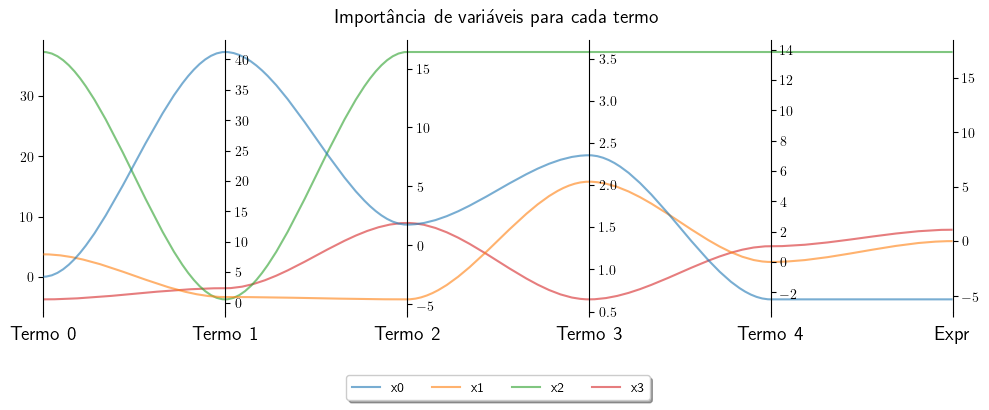

In [60]:
fig, axs = plt.subplots(figsize=(10,5))

axs, mycoef = varimp(axs, bestsol, X, y, ynames)
axs.set_title(f'Importância de variáveis para cada termo', fontsize=14, pad=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

print(f'Importâncias originais:\n\t{coef}')

# Parece que a soma dos deltas dá alguns valores próximos às importâncias reais
print(f'soma dos deltas do nosso método:\n\t{mycoef}')

# Será que é um bom jeito de determinar quais são importantes?
threshold = np.mean(mycoef)
important = [(True if mc>threshold else False) for mc in mycoef]

print(f'Variáveis com deltas acima da média de deltas ({np.mean(mycoef)}):\n\t{important}')

plt.show()

Melhor solução: -3.675*sin(x0^5 * x1^5 * x2^4 * x3^5) + 0.379*sqrt.abs(x0^4 * x1^4 * x2^2 * x3^4) + -0.0*sqrt.abs(x0^-3 * x1^-3 * x3^-4) + -1.332*cos(x1 * x2 * x3^-3) + -1.778*sin(x0^-4 * x1^3 * x2^3 * x3^5) + 0.686
Importâncias originais:
	[0. 0. 0. 0.]
soma dos deltas do nosso método:
	[0.47705032 0.62773215 0.36759758 0.55326449]
Variáveis com deltas acima da média de deltas (0.5064111324901805):
	[False, True, False, True]


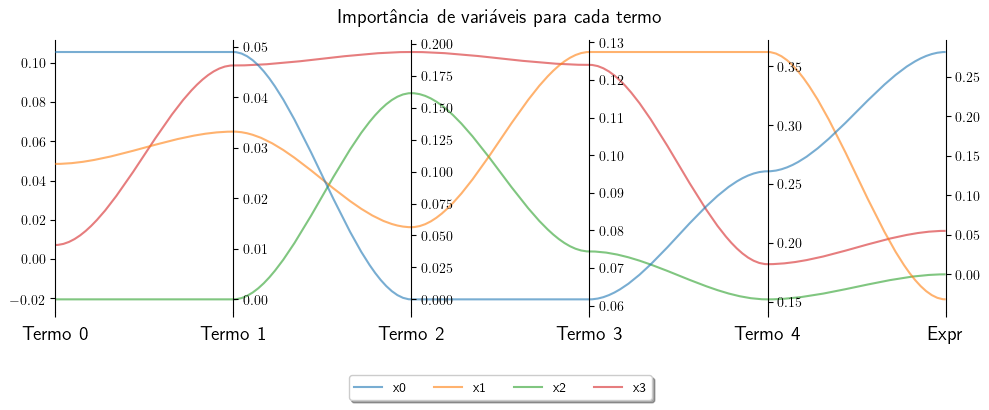

In [62]:
# Sem ninguém importante

X, y, coef = datasets.make_regression(n_samples=200, n_features=4,
                                      n_informative=0, noise=5,
                                      coef=True, random_state=0)

ynames     = [f'x{i}' for i, _ in enumerate(X[0])]

itea = sr.ITEA(**params)
bestsol = itea.run(X, y, log=None, verbose=False)

print(f'Melhor solução: {bestsol}')

fig, axs = plt.subplots(figsize=(10,5))

axs, mycoef = varimp(axs, bestsol, X, y, ynames)
axs.set_title(f'Importância de variáveis para cada termo', fontsize=14, pad=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

print(f'Importâncias originais:\n\t{coef}')

# Parece que a soma dos deltas dá alguns valores próximos às importâncias reais
print(f'soma dos deltas do nosso método:\n\t{mycoef}')

# Será que é um bom jeito de determinar quais são importantes?
threshold = np.mean(mycoef)
important = [(True if mc>threshold else False) for mc in mycoef]

print(f'Variáveis com deltas acima da média de deltas ({np.mean(mycoef)}):\n\t{important}')

plt.show()